# Shortest Path using Reinforcement Learning (Q-Learning: Temporal Difference method or SARSA)

In [7]:
import numpy as np
import pylab as plt
import networkx as nx #for graphs
import pandas as pd

In [8]:
edge_list = [(0,2),(0,1),(0,3),(2,4),(5,6),(7,4),(0,6),(5,3),(3,7),(0,8)]

In [9]:
goal = 7

In [10]:
G = nx.Graph()
G.add_edges_from(edge_list)

In [11]:
position = nx.spring_layout(G)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


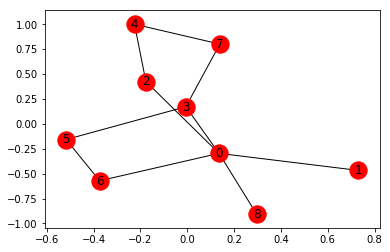

In [12]:
nx.draw_networkx_nodes(G, position)
nx.draw_networkx_edges(G, position)
nx.draw_networkx_labels(G, position)
plt.show()

In [13]:
# Setting up a rewards matrix
SIZE_MATRIX = 9 # As we have 9 nodes
R = np.matrix(np.ones(shape=(SIZE_MATRIX, SIZE_MATRIX)))
R *= -1
R

matrix([[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.]])

In [14]:
for edge in edge_list:
    print(edge)
    if edge[1] == goal:
        R[edge] = 100
    else:
        R[edge] = 0
    # As this is an undirected graph, do the following
    if edge[0] == goal:
        R[edge[::-1]] = 100
    else:
        R[edge[::-1]] = 0

(0, 2)
(0, 1)
(0, 3)
(2, 4)
(5, 6)
(7, 4)
(0, 6)
(5, 3)
(3, 7)
(0, 8)


In [15]:
# Reward for goal is always 100
R[goal, goal] = 100
R

matrix([[ -1.,   0.,   0.,   0.,  -1.,  -1.,   0.,  -1.,   0.],
        [  0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,  -1.,  -1.,  -1.,   0.,  -1., 100.,  -1.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1., 100.,  -1.],
        [ -1.,  -1.,  -1.,   0.,  -1.,  -1.,   0.,  -1.,  -1.],
        [  0.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,   0.,   0.,  -1.,  -1., 100.,  -1.],
        [  0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]])

In [16]:
gamma = 0.8 # for future rewards

In [17]:
Q = np.matrix(np.zeros([SIZE_MATRIX, SIZE_MATRIX]))
Q

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# function that provides us the available actions.
def get_available_actions(state):
    current_state_row = R[state,]
    available_actions = np.where(current_state_row >= 0)[1]
    return available_actions

In [20]:
# just trying the above funtion - receiving the available_actions.
get_available_actions(0)

array([1, 2, 3, 6, 8])

In [21]:
# function that helps us in the exploration, receiving the next_actions.
def sample_next_action(available_actions):
    next_action = int(np.random.choice(available_actions, size=1))
    return next_action

In [22]:
# testing the above function
sample_next_action(get_available_actions(0))

6

In [32]:
# function for updating the Q-values in the existing Q-table
def update(current_state, action, gamma):
    max_index = np.where(Q[action, ] == np.max(Q[action, ]))[1]
    print('max_index', max_index.shape)
    
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index]
    Q[current_state, action] = R[current_state, action] + gamma * max_value
    print('max_value', R[current_state, action] + gamma * max_value)

In [24]:
# Testing
initial_state = 0

In [26]:
available_actions = get_available_actions(initial_state)

In [30]:
action = sample_next_action(available_actions)

3

In [36]:
update(initial_state, action, gamma)
Q

max_index (9,)
max_value 0.0


matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
# Q-Value Iteration for exploration of graph for populating the Q-Table
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_actions = get_available_actions(current_state)
    action = sample_next_action(available_actions)
    update(current_state, action, gamma)

max_index (9,)
max_value 0.0
max_index (9,)
max_value 100.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (1,)
max_value 80.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (1,)
max_value 64.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (1,)
max_value 80.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index (9,)
max_value 0.0
max_index

max_index (1,)
max_value 314.79698054185985
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 491.87028209665596
max_index (1,)
max_value 391.87028209665596
max_index (1,)
max_value 493.4962256773248
max_index (1,)
max_value 313.4962256773248
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 313.4962256773248
max_index (1,)
max_value 493.4962256773248
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 391.87028209665596
max_index (1,)
max_value 309.83785262081994
max_index (2,)
max_value 247.87028209665596
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 314.79698054185985
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 313.4962256773248
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 309.83785262081994
max_index (1,)
max_value 493.4962256773248
max_index (1,)
max_value 494.796980541

In [38]:
print("Trained Q-Table")
pd.DataFrame(Q)

Trained Q-Table


,0,1,2,3,4,5,6,7,8
0,0.000000,254.295075,318.63606,397.336054,0.000000,0.000000,250.796981,0.000000,250.796981
1,317.868843,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,317.868843,0.000000,0.00000,0.000000,398.295075,0.000000,0.000000,0.000000,0.000000
3,317.868843,0.000000,0.00000,0.000000,0.000000,317.336054,0.000000,496.670068,0.000000
4,0.000000,0.000000,318.63606,0.000000,0.000000,0.000000,0.000000,497.868843,0.000000
5,0.000000,0.000000,0.00000,396.670068,0.000000,0.000000,254.295075,0.000000,0.000000
6,317.868843,0.000000,0.00000,0.000000,0.000000,317.336054,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,397.336054,398.295075,0.000000,0.000000,498.636060,0.000000
8,313.496226,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
# Normalizing the Table data
print("Normalized Table")
pd.DataFrame(Q / np.max(Q) * 100)

Normalized Table


,0,1,2,3,4,5,6,7,8
0,0.000000,50.998132,63.901528,79.684581,0.00000,0.000000,50.296599,0.000000,50.296599
1,63.747665,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,63.747665,0.000000,0.000000,0.000000,79.87691,0.000000,0.000000,0.000000,0.000000
3,63.747665,0.000000,0.000000,0.000000,0.00000,63.640815,0.000000,99.605726,0.000000
4,0.000000,0.000000,63.901528,0.000000,0.00000,0.000000,0.000000,99.846137,0.000000
5,0.000000,0.000000,0.000000,79.551019,0.00000,0.000000,50.998132,0.000000,0.000000
6,63.747665,0.000000,0.000000,0.000000,0.00000,63.640815,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,79.684581,79.87691,0.000000,0.000000,100.000000,0.000000
8,62.870749,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [42]:
# finding the shortest path to goal node 7
current_state = 0
steps = [current_state] # this is where we start

while current_state != goal: #goal is the target we wanted to reach
    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size=1)) # randomly choosing 
    else:
        next_step_index = int(next_step_index)
    steps.append(next_step_index)
    current_state = next_step_index

In [43]:
print("Most effective path")
print(steps)

Most effective path
[0, 3, 7]
